In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from random import randint
import pickle,glob, cv2
from shared.segmentationHelpers import get_num_images, generate_image_segmentation_labels

In [30]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    # some implementations don't square y_pred
    denominator = tf.reduce_sum(y_true + tf.square(y_pred))
    return 1 -numerator / (denominator + tf.keras.backend.epsilon()) 

def loadModel(configName, scheme):
    path = '../models/segmenters/'+scheme+'/'+configName+'/'
    modelPath = path + 'model'
    historyPath = path +'history.pickle'
    
    model = tf.keras.models.load_model(modelPath, custom_objects={'dice_loss':                   
    dice_loss})
    with open(historyPath, 'rb') as f:
        history = pickle.load(f)
        
    return (model,history)

In [4]:
def showLoss(history):
    loss = history['loss']
    val_loss = history['val_loss']
    plt.plot(loss, label='Training')
    plt.plot(val_loss, label='Validation') 
    plt.ylabel('Loss (Binary CE)')
    plt.xlabel('Epoc')
    plt.legend()
    plt.show()

In [7]:
def diceScore(map1,map2):
    '''
    :param map1,map2 - are both binary matrices of depth 1
    '''
    mapIntersection = np.logical_and(map1,map2)
    
    intersection = sum(sum(mapIntersection))
    region1 = sum(sum(map1))
    region2 = sum(sum(map2))
    
    return (2*intersection)/(region1+region2)

def getAllMasks(method, segmentationScheme, dataDir):
    
    def flatten(image):
        imageNew = image[:,:,0]+image[:,:,1]+image[:,:,2]
        return imageNew
    
    def binarize(image):
        imageNew = np.zeros((image.shape),dtype='bool')
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                imageNew[i,j] = (image[i,j]>100)
                
        return imageNew
        
    
    masksPath = "{}/segmentation/{}/{}/labels/".format(dataDir,segmentationScheme,method)
    labelsPath = "{}/segmentation/{}/labels.pickle".format(dataDir,segmentationScheme)
    
    with open(labelsPath,'rb') as f:
        data = pickle.load(f)
    data = data[method]
    masks = [cv2.imread("{}{}.jpg".format(masksPath,image)) for image in data]
    masks = [flatten(mask) for mask in masks]
    masks = [binarize(mask) for mask in masks]
    
    return masks
    
def getAllPredictions(model, method,segmentationScheme,dataDir):
    BATCH_SIZE_TEST = 8
    NUM_SAMPLES_TEST =  get_num_images(method,segmentationScheme, dataDir)
    STEPS_TEST = ceil(NUM_SAMPLES_TEST/BATCH_SIZE_TEST)    
    decoded_imgs = model.predict_generator(generate_image_segmentation_labels(method,segmentationScheme ,BATCH_SIZE_TEST, dataDir=dataDir,squashOutput=True),steps=STEPS_TEST)
    
    predictionsList = [decoded_imgs[i,:,:,0] for i in range(decoded_imgs.shape[0])]
    
    return predictionsList

def ThresholdPredictions(predictions, t_val=0.5):
    
    def threshold(image,t_val):
        imageNew = np.zeros((image.shape),dtype='bool')
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                imageNew[i,j] = (image[i,j]>t_val)
        return imageNew
    
    logicalMasks = [threshold(item,t_val)for item in predictions]
    return logicalMasks

def meanDiceScore(list1,list2):
    '''
    computes the mean dice score between 2 lists
    '''
    diceScores = [diceScore(list1[i],list2[i]) for i in range(len(list1))]
    total = sum(diceScores)
    mean = total/len(diceScores)
    return mean

def diceAtThresholds(actual,predicted, thresholds):
    
    meanDices = []
    for th in thresholds:
        thresholdedList = ThresholdPredictions(predicted,t_val = th)
        meanDice = meanDiceScore(actual,thresholdedList)
        print(meanDice)
        meanDices.append(meanDice)
        
    return meanDices

def generatePredictions(model,method,segmentationScheme,dataPath):
    BATCH_SIZE_TEST = 8
    NUM_SAMPLES_TEST =  get_num_images(method,segmentationScheme, dataPath)
    STEPS_TEST = ceil(NUM_SAMPLES_TEST/BATCH_SIZE_TEST)

    decoded_imgs = model.predict_generator(generate_image_segmentation_labels(method,segmentationScheme ,BATCH_SIZE_TEST, dataDir=dataPath,squashOutput=True),steps=STEPS_TEST)
    return decoded_imgs

def plotPlots(images):
    num_images = len(images)
    plt.figure(figsize=(15, 6))
    for i, image in enumerate(images):
        # display original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        


In [65]:
(model_fb_mini,history_fb_mini) = loadModel('config1','foregroundBackground')
(model_fb_midi,history_fb_midi) = loadModel('config2','foregroundBackground')
(model_po_mini,history_po_mini) = loadModel('config4','personOnly')
(model_po_midi,history_po_midi) = loadModel('config5','personOnly')

Instructions for updating:
Use tf.cast instead.


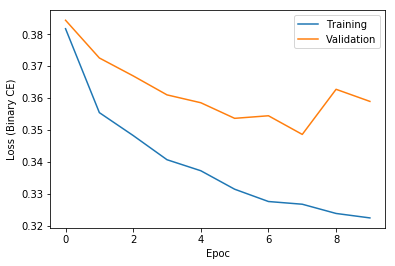

In [35]:
(model_fb_midi_dice_loss,history_fb_midi_dice_loss) = loadModel('config6','foregroundBackground')
showLoss(history_fb_midi_dice_loss)
decoded_imgs_fb_midi_dice_loss = generatePredictions(model_fb_midi_dice_loss,'validation','foregroundBackground','../data/')

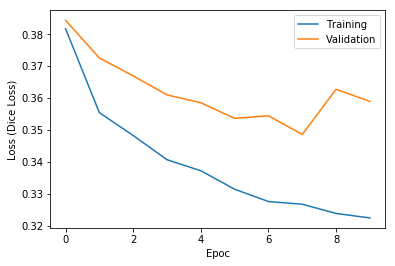

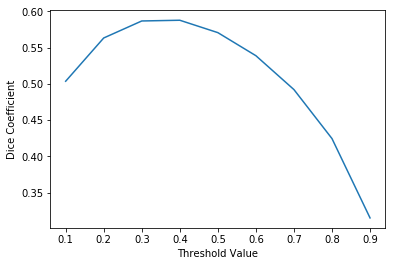

In [64]:
loss = history_fb_midi_dice_loss['loss']
val_loss = history_fb_midi_dice_loss['val_loss']
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation') 
plt.ylabel('Loss (Dice Loss)')
plt.xlabel('Epoc')
plt.legend()
plt.show()

plt.plot(t_list,curve_fb_midi_dice_loss)
plt.ylabel('Dice Coefficient')
plt.xlabel('Threshold Value')
plt.show()

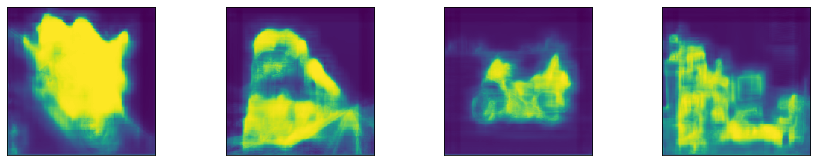

In [36]:
plotPlots([decoded_imgs_fb_midi_dice_loss[3,:,:,0],decoded_imgs_fb_midi_dice_loss[16,:,:,0],decoded_imgs_fb_midi_dice_loss[25,:,:,0],decoded_imgs_fb_midi_dice_loss[29,:,:,0]])

In [38]:
t_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
labelMasksForegroundBackgroundTraining = getAllMasks('training','foregroundBackground','../data/')
print('o')
curve_fb_midi_dice_loss = diceAtThresholds(labelMasksForegroundBackgroundTraining,getAllPredictions(model_fb_midi_dice_loss,'training','foregroundBackground','../data/'), t_list)
print(curve_fb_midi_dice_loss)

o
0.5035806476538147
0.5632716954663475
0.5867345985720697
0.5877379419015236
0.5706462409624159
0.5388067042739333
0.49204944885408136
0.4244372484139036
0.31498010304429197
[0.5035806476538147, 0.5632716954663475, 0.5867345985720697, 0.5877379419015236, 0.5706462409624159, 0.5388067042739333, 0.49204944885408136, 0.4244372484139036, 0.31498010304429197]


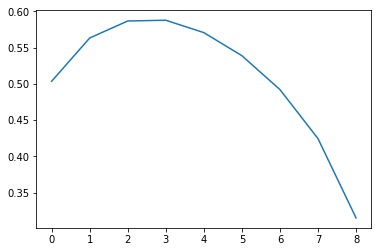

In [39]:
plt.plot(curve_fb_midi_dice_loss)
plt.show()

In [42]:
best_fb_midi_dice_loss = ThresholdPredictions(getAllPredictions(model_fb_midi_dice_loss,'test', 'foregroundBackground','../data/'), t_val=0.4)

In [57]:
labelMasksForegroundBackgroundTest = getAllMasks('test','foregroundBackground','../data/')

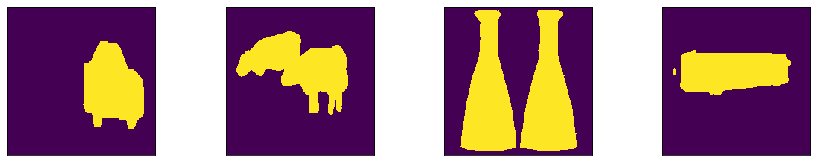

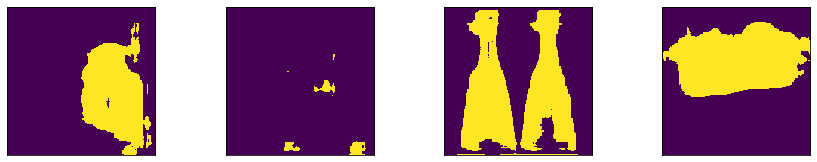

In [62]:
plotPlots([labelMasksForegroundBackgroundTest[3],labelMasksForegroundBackgroundTest[19],labelMasksForegroundBackgroundTest[26],labelMasksForegroundBackgroundTest[12]])
plotPlots([best_fb_midi_dice_loss[3],best_fb_midi_dice_loss[19], best_fb_midi_dice_loss[26], best_fb_midi_dice_loss[12]])

In [ ]:
showLoss(history_fb_mini)
showLoss(history_fb_midi)
showLoss(history_po_mini)
showLoss(history_po_midi)

In [103]:
labelMasksPersonOnly = getAllMasks('validation','personOnly','../data/')
labelMasksForegroundBackground = getAllMasks('validation','foregroundBackground','../data/')

In [94]:
decoded_imgs_fb_mini = generatePredictions(model_fb_mini,'validation','foregroundBackground','../data/')
decoded_imgs_fb_midi = generatePredictions(model_fb_midi,'validation','foregroundBackground','../data/')
decoded_imgs_po_mini = generatePredictions(model_po_mini,'validation','personOnly','../data/')
decoded_imgs_po_midi = generatePredictions(model_po_midi,'validation','personOnly','../data/')

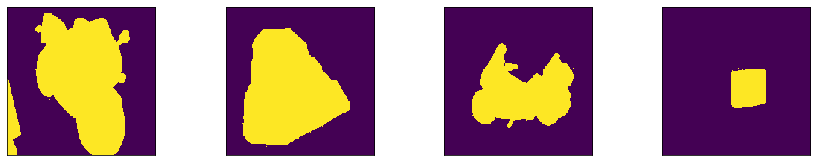

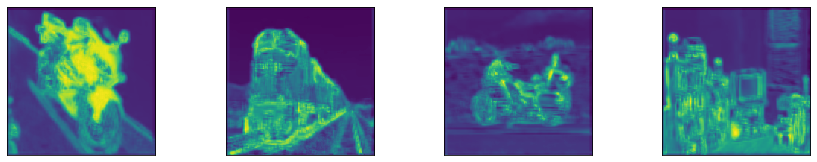

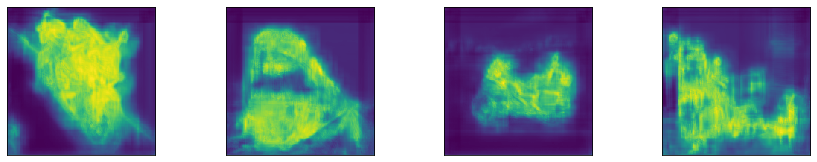

In [146]:
plotPlots([labelMasksForegroundBackground[3],labelMasksForegroundBackground[16],labelMasksForegroundBackground[25],labelMasksForegroundBackground[29]])
plotPlots([decoded_imgs_fb_mini[3,:,:,0],decoded_imgs_fb_mini[16,:,:,0],decoded_imgs_fb_mini[25,:,:,0],decoded_imgs_fb_mini[29,:,:,0]])
plotPlots([decoded_imgs_fb_midi[3,:,:,0],decoded_imgs_fb_midi[16,:,:,0],decoded_imgs_fb_midi[25,:,:,0],decoded_imgs_fb_midi[29,:,:,0]])

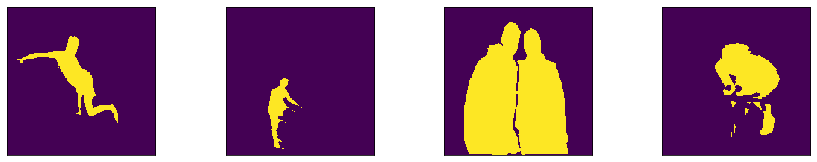

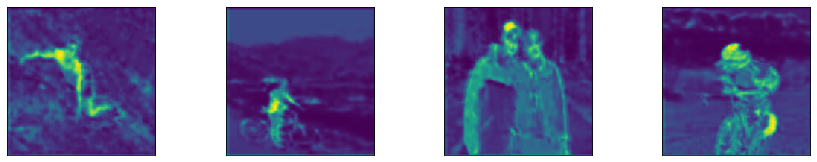

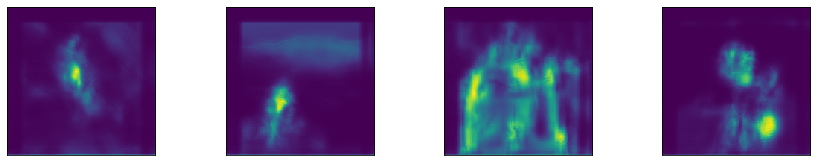

In [153]:
plotPlots([labelMasksPersonOnly[10],labelMasksPersonOnly[17],labelMasksPersonOnly[25],labelMasksPersonOnly[29]])
plotPlots([decoded_imgs_po_mini[10,:,:,0],decoded_imgs_po_mini[17,:,:,0],decoded_imgs_po_mini[25,:,:,0],decoded_imgs_po_mini[29,:,:,0]])
plotPlots([decoded_imgs_po_midi[10,:,:,0],decoded_imgs_po_midi[17,:,:,0],decoded_imgs_po_midi[25,:,:,0],decoded_imgs_po_midi[29,:,:,0]])

In [68]:
t_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
labelMasksPersonOnlyTraining = getAllMasks('training','personOnly','../data/')
labelMasksForegroundBackgroundTraining = getAllMasks('training','foregroundBackground','../data/')
print('o')


o


In [156]:
curve_fb_mini = diceAtThresholds(labelMasksForegroundBackgroundTraining,getAllPredictions(model_fb_mini,'training', 'foregroundBackground','../data/'), t_list)
print(curve_fb_mini)
curve_fb_midi = diceAtThresholds(labelMasksForegroundBackgroundTraining,getAllPredictions(model_fb_midi,'training','foregroundBackground','../data/'), t_list)
print(curve_fb_midi)
curve_po_mini = diceAtThresholds(labelMasksPersonOnlyTraining,getAllPredictions(model_po_mini,'training','personOnly','../data/'), t_list)
print(curve_po_mini)
curve_po_midi = diceAtThresholds(labelMasksPersonOnlyTraining,getAllPredictions(model_po_midi,'training','personOnly','../data/'), t_list)
print(curve_po_midi)

0.4761462877742826
0.5362484497576312
0.5448063367238142
0.4994985678964268
0.3514474284910489
0.1696593164725215
0.05320875341241844
0.009779194289478894
0.000555966352327915
[0.4761462877742826, 0.5362484497576312, 0.5448063367238142, 0.4994985678964268, 0.3514474284910489, 0.1696593164725215, 0.05320875341241844, 0.009779194289478894, 0.000555966352327915]
0.5152592206881905
0.5714694087713326
0.582728829851604
0.5760703273199272
0.5489370810892661
0.4749384632205186
0.3018831670779467
0.09844185269403462
0.009851651653914039
[0.5152592206881905, 0.5714694087713326, 0.582728829851604, 0.5760703273199272, 0.5489370810892661, 0.4749384632205186, 0.3018831670779467, 0.09844185269403462, 0.009851651653914039]
0.296797349685697
0.3440602781593183
0.2948293708657804
0.19628251567884483
0.09409326053341877
0.0188044111403348
8.666900672984837e-06
0.0
0.0
[0.296797349685697, 0.3440602781593183, 0.2948293708657804, 0.19628251567884483, 0.09409326053341877, 0.0188044111403348, 8.6669006729848

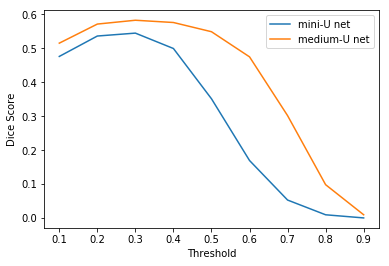

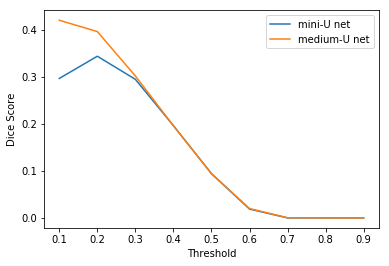

In [160]:
plt.plot(t_list,curve_fb_mini, label='mini-U net')
plt.plot(t_list,curve_fb_midi, label='medium-U net')
plt.ylabel('Dice Score')
plt.xlabel('Threshold')
plt.legend()
plt.show()

plt.plot(t_list,curve_po_mini, label='mini-U net')
plt.plot(t_list,curve_po_midi, label='medium-U net')
plt.ylabel('Dice Score')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [161]:
best_fb_mini = ThresholdPredictions(getAllPredictions(model_fb_mini,'test', 'foregroundBackground','../data/'), t_val=0.3)
print(1)
best_fb_midi = ThresholdPredictions(getAllPredictions(model_fb_midi,'test', 'foregroundBackground','../data/'), t_val=0.3)
print(2)
best_po_mini = ThresholdPredictions(getAllPredictions(model_po_mini,'test', 'personOnly','../data/'), t_val=0.2)
print(3)
best_po_midi = ThresholdPredictions(getAllPredictions(model_po_midi,'test', 'personOnly','../data/'), t_val=0.1)
print(4)

1
2
3
4


In [167]:
labelMasksPersonOnlyTest = getAllMasks('test','personOnly','../data/')
labelMasksForegroundBackgroundTest = getAllMasks('test','foregroundBackground','../data/')

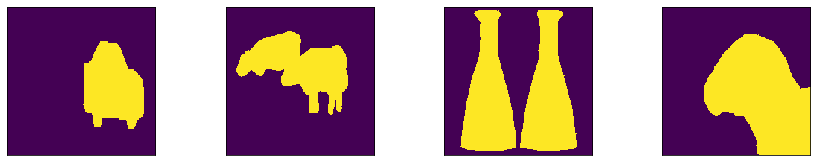

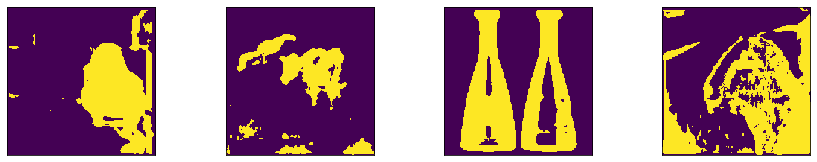

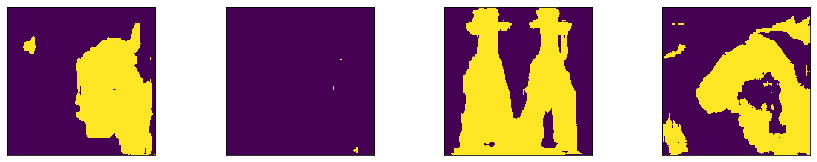

In [173]:
plotPlots([labelMasksForegroundBackgroundTest[3],labelMasksForegroundBackgroundTest[19],labelMasksForegroundBackgroundTest[26],labelMasksForegroundBackgroundTest[29]])
plotPlots([best_fb_mini[3],best_fb_mini[19], best_fb_mini[26], best_fb_mini[29]])
plotPlots([best_fb_midi[3],best_fb_midi[19], best_fb_midi[26], best_fb_midi[29]])

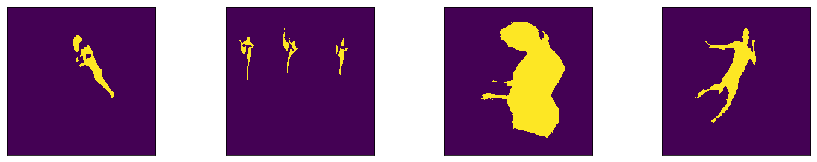

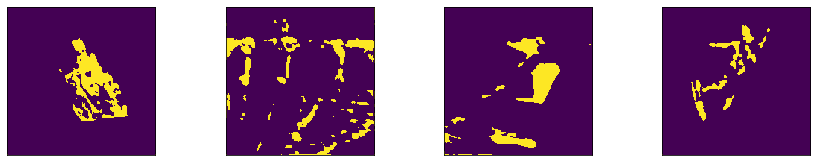

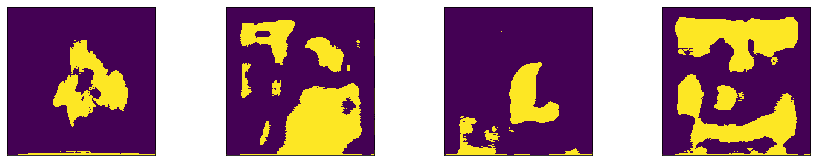

In [178]:
plotPlots([labelMasksPersonOnlyTest[0],labelMasksPersonOnlyTest[19],labelMasksPersonOnlyTest[26],labelMasksPersonOnlyTest[28]])
plotPlots([best_po_mini[0],best_po_mini[19], best_po_mini[26], best_po_mini[28]])
plotPlots([best_po_midi[0],best_po_midi[19], best_po_midi[26], best_po_midi[28]])

In [69]:
curve_fb_mini = diceAtThresholds(labelMasksForegroundBackgroundTraining,getAllPredictions(model_fb_mini,'training', 'foregroundBackground','../data/'), [0.0])

0.4641398054313813


In [70]:
curve_po_mini = diceAtThresholds(labelMasksPersonOnlyTraining,getAllPredictions(model_po_mini,'training','personOnly','../data/'), [0.0])

0.22805091274927988
